## Sommaire

**Contexte et objectif du projet**<br>
L’Organisation nationale de lutte contre le faux-monnayage, ou ONCFM, est une organisation publique ayant pour objectif de mettre en place des méthodes d’identification des contrefaçons des billets en euros. Dans le cadre de cette lutte, nous souhaitons mettre en place un algorithme qui soit capable de différencier automatiquement les vrais des faux billets.
Il faut construire un algorithme qui, à partir des caractéristiques géométriques d’un billet, serait capable de définir si ce dernier est un vrai ou un faux billet.

**Données**

Le jeu de données est celui utilisé dans le TP de régression (avec les données de margin_low imputées)

***Variable cible:***
is_genuine représente la variable à prédire (True: faux billet; False: 

***Variables explicatives:*** six informations géométriques sur un billet :<br>
- length : la longueur du billet (en mm) ;
- height_left : la hauteur du billet (mesurée sur le côté gauche, en mm) ; 
- height_right : la hauteur du billet (mesurée sur le côté droit, en mm) ;
- margin_up : la marge entre le bord supérieur du billet et l'image de celui-ci (en mm) ; 
- margin_low : la marge entre le bord inférieur du billet et l'image de celui-ci (en mm) ; 
- diagonal : la diagonale du billet (en mm).

## Packages

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns
from plotly.subplots import make_subplots
from sklearn import set_config
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             ConfusionMatrixDisplay,
                             confusion_matrix,
                             classification_report,
                            )
from sklearn.model_selection import (train_test_split,
                                     cross_val_score,
                                     cross_validate,
                                     cross_val_predict,
                                     GridSearchCV,
                                     learning_curve,
                                    )

from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from ydata_profiling import ProfileReport
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, DiscriminationThreshold


set_config(display="diagram", print_changed_only=True)

In [2]:
pwd

'/Users/mouslydiaw/Downloads/initiation-machine-learning/notebooks'

In [3]:
# Return a new path pointing to the parent of the current working directory
HOME_DIR = Path.cwd().parent

# create a variable for data directory
DATA_DIR = Path(HOME_DIR, "data")

print(f"Work directory: {HOME_DIR} \nData directory: {DATA_DIR}")

Work directory: /Users/mouslydiaw/Downloads/initiation-machine-learning 
Data directory: /Users/mouslydiaw/Downloads/initiation-machine-learning/data


## Données

In [4]:
# you must put the CSV file billets.csv in data directory, cf above cell
data = pd.read_csv(Path(DATA_DIR, "billets.csv"), sep=";")
# ou "billets-completed.csv" avec les données imputées avec la régression linéaire
data.shape  # data frame dimensions (nb rows, nb columns)

(1500, 7)

In [5]:
data.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   
1        True    171.46       103.36        103.66        3.77       2.99   
2        True    172.69       104.48        103.50        4.40       2.94   
3        True    171.36       103.91        103.94        3.62       3.01   
4        True    171.73       104.28        103.46        4.04       3.48   

   length  
0  112.83  
1  113.09  
2  113.16  
3  113.51  
4  112.54

In [6]:
# Print a concise summary of a DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [7]:
# Generate descriptive statistics
data.describe(include="all")

is_genuine     diagonal  height_left  height_right   margin_low  \
count        1500  1500.000000  1500.000000   1500.000000  1463.000000   
unique          2          NaN          NaN           NaN          NaN   
top          True          NaN          NaN           NaN          NaN   
freq         1000          NaN          NaN           NaN          NaN   
mean          NaN   171.958440   104.029533    103.920307     4.485967   
std           NaN     0.305195     0.299462      0.325627     0.663813   
min           NaN   171.040000   103.140000    102.820000     2.980000   
25%           NaN   171.750000   103.820000    103.710000     4.015000   
50%           NaN   171.960000   104.040000    103.920000     4.310000   
75%           NaN   172.170000   104.230000    104.150000     4.870000   
max           NaN   173.010000   104.880000    104.950000     6.900000   

          margin_up      length  
count   1500.000000  1500.00000  
unique          NaN         NaN  
top             NaN         NaN  
freq            NaN         NaN  
mean       3.151473   112.67850  
std        0.231813     0.87273  
min        2.270000   109.49000  
25%        2.990000   112.03000  
50%        3.140000   112.96000  
75%        3.310000   113.34000  
max        3.910000   114.44000

## EDA

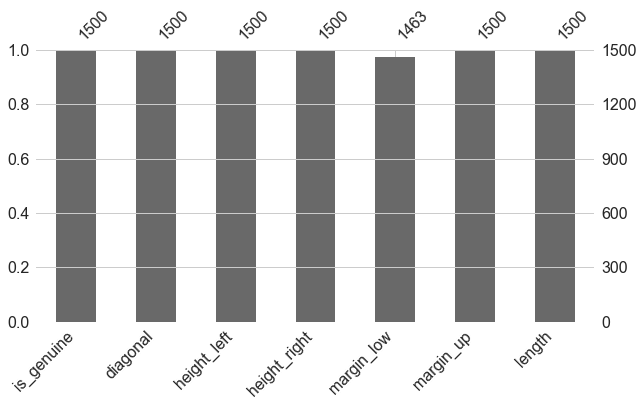

In [8]:
# A bar chart visualization of the nullity of the given DataFrame.
msno.bar(data, figsize=(10, 5));

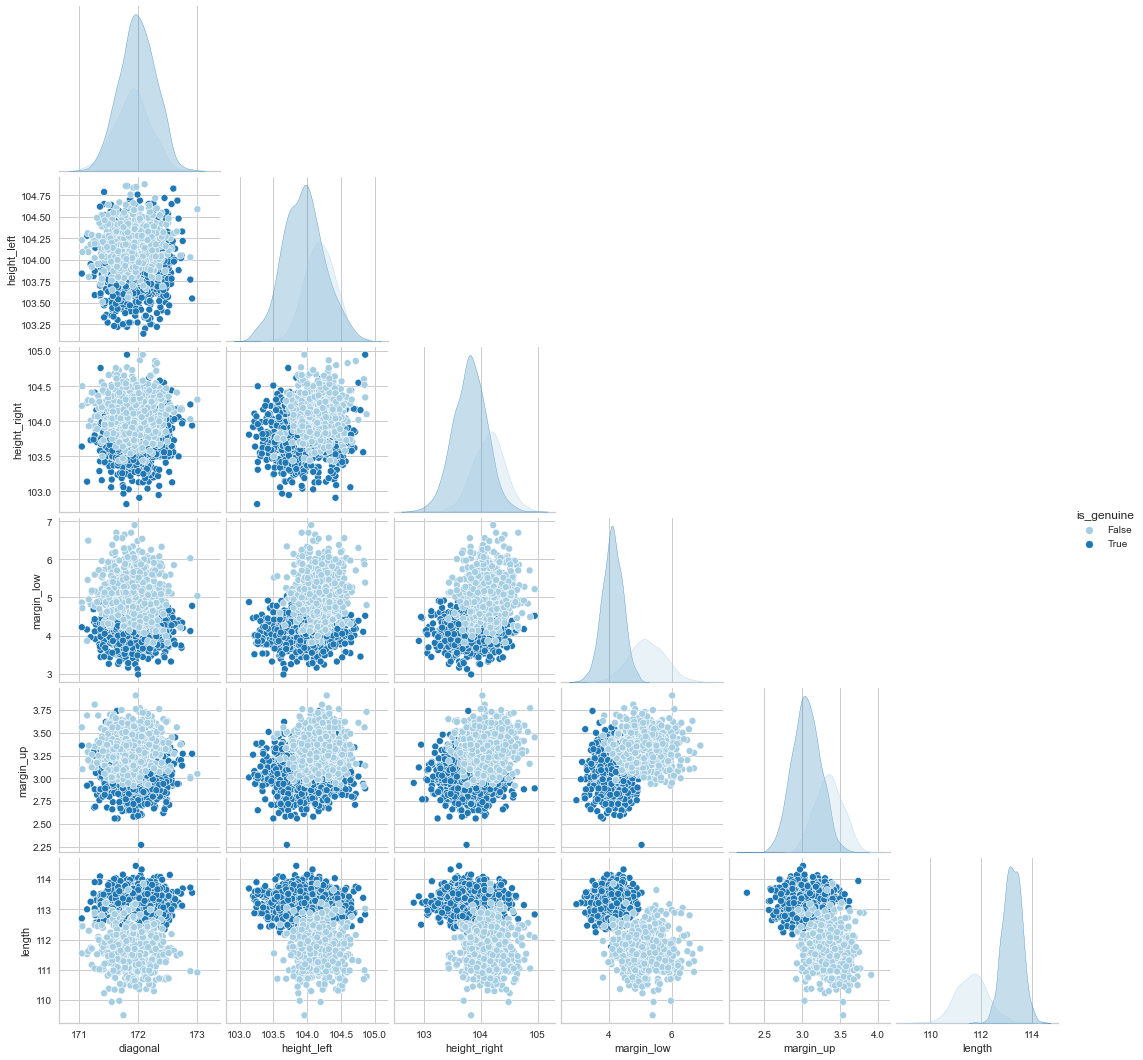

In [9]:
sns.pairplot(data, hue="is_genuine", palette="Paired", corner=True, diag_kind="kde");

In [10]:
# Generate a profile report from a Dataset stored as a pandas `DataFrame`.

profile = ProfileReport(data, title="Profiling Report")
profile.to_notebook_iframe()  # Used to output the HTML representation to a Jupyter notebook.
# profile.to_file("data_report.html")  # Write the report to a file.

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Modeling

### Train & test split

In [12]:
X = data.drop("is_genuine", axis=1)  # toutes les données sauf la variable cible
y = data.loc[:, 'is_genuine']

In [13]:
X.head()

diagonal  height_left  height_right  margin_low  margin_up  length
0    171.81       104.86        104.95        4.52       2.89  112.83
1    171.46       103.36        103.66        3.77       2.99  113.09
2    172.69       104.48        103.50        4.40       2.94  113.16
3    171.36       103.91        103.94        3.62       3.01  113.51
4    171.73       104.28        103.46        4.04       3.48  112.54

In [14]:
y.value_counts()

True     1000
False     500
Name: is_genuine, dtype: int64

In [15]:
y.head()

0    True
1    True
2    True
3    True
4    True
Name: is_genuine, dtype: bool

In [22]:
# Séparons nos données en un jeu d'entraînement et un jeu de test :
# 30% des données dans le jeu de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Train set - X: {X_train.shape} ; y: {y_train.shape} \nTest set - X: {X_test.shape} ; y: {y_test.shape}")

Train set - X: (1050, 6) ; y: (1050,) 
Test set - X: (450, 6) ; y: (450,)


In [23]:
y_train.value_counts(normalize=True)

True     0.666667
False    0.333333
Name: is_genuine, dtype: float64

In [24]:
y_test.value_counts(normalize=True)

True     0.666667
False    0.333333
Name: is_genuine, dtype: float64

### Pipeline

In [25]:
# définition de Pipeline de régression avec Pipeline (c'est à nous de données les noms de chaque étape du workflow)
clf_pipe = Pipeline(steps=[("imputer", SimpleImputer(strategy="mean")),
                           ("scaler", MinMaxScaler()),
                           ("classifier", LogisticRegression(solver="saga")),
                          ]
                   )
clf_pipe

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('classifier', LogisticRegression(solver='saga'))])

import sklearn
sklearn.metrics.SCORERS.keys()

In [18]:
scores = cross_validate(clf_pipe, X_train, y_train, cv=5,
                        scoring=["f1_macro"],
                        return_train_score=True,
                        verbose=True,
                       )
scores

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


{'fit_time': array([0.02689099, 0.01514196, 0.01070404, 0.05678916, 0.02384901]),
 'score_time': array([0.01183105, 0.0041852 , 0.00383091, 0.00396991, 0.00648379]),
 'test_f1_macro': array([0.98895202, 0.98904081, 0.97825186, 0.98904081, 0.97790404]),
 'train_f1_macro': array([0.98356121, 0.98213792, 0.98349532, 0.98352844, 0.98630101])}

In [19]:
pd.DataFrame(scores)

fit_time  score_time  test_f1_macro  train_f1_macro
0  0.026891    0.011831       0.988952        0.983561
1  0.015142    0.004185       0.989041        0.982138
2  0.010704    0.003831       0.978252        0.983495
3  0.056789    0.003970       0.989041        0.983528
4  0.023849    0.006484       0.977904        0.986301

### Analyse des performances

In [20]:
clf_pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('classifier', LogisticRegression(solver='saga'))])

In [21]:
y_train_pred =  clf_pipe.predict(X_train)
y_test_pred =  clf_pipe.predict(X_test)

In [23]:
# liste des labels du modèle entrainé
class_names = clf_pipe.classes_
class_names

array([False,  True])

In [28]:
confusion_matrix(y_train, y_train_pred, normalize=None)  #'true', 'pred', 'all', None

array([[327,  12],
       [  2, 709]])

Confusion matrix, without normalization
[[155   6]
 [  0 289]]
Normalized confusion matrix
[[0.96273292 0.03726708]
 [0.         1.        ]]


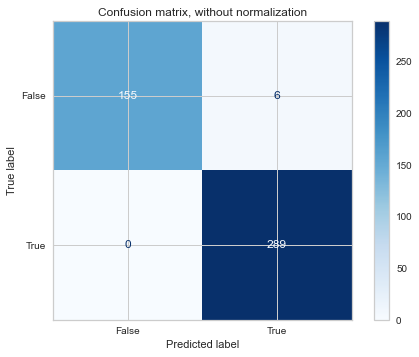

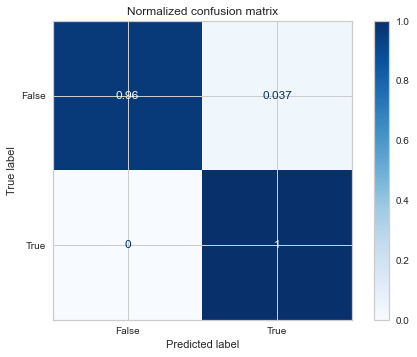

In [29]:
# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        clf_pipe,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

/Users/mouslydiaw/opt/anaconda3/envs/python39/lib/python3.9/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


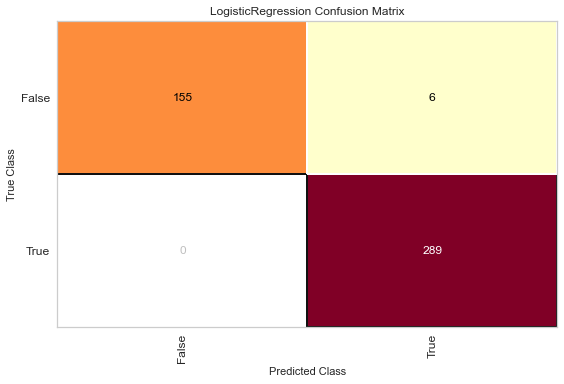

<AxesSubplot:title={'center':'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [58]:
# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(clf_pipe, classes=class_names)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.show()

In [44]:
confusion_matrix(y_test, y_test_pred)

array([[155,   6],
       [  0, 289]])

In [30]:
for name, y_true, y_pred in [("Train", y_train, y_train_pred),
                             ("Test", y_test, y_test_pred),
                            ]:
    print(f"{name} ==========================================\n")
    print(classification_report(y_true, y_pred), end="\n\n\n")

Train ==========================================

              precision    recall  f1-score   support

       False       0.99      0.96      0.98       339
        True       0.98      1.00      0.99       711

    accuracy                           0.99      1050
   macro avg       0.99      0.98      0.98      1050
weighted avg       0.99      0.99      0.99      1050



Test ==========================================

              precision    recall  f1-score   support

       False       1.00      0.96      0.98       161
        True       0.98      1.00      0.99       289

    accuracy                           0.99       450
   macro avg       0.99      0.98      0.99       450
weighted avg       0.99      0.99      0.99       450





/Users/mouslydiaw/opt/anaconda3/envs/python39/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


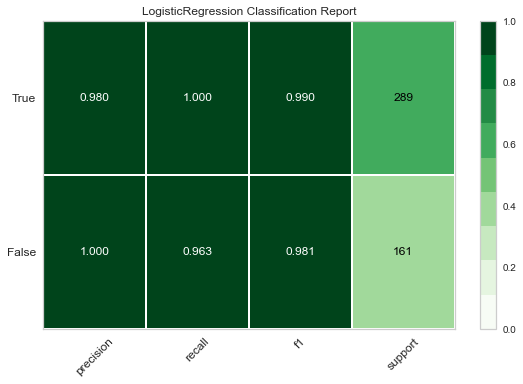

<AxesSubplot:title={'center':'LogisticRegression Classification Report'}>

In [71]:
cr_visualizer = ClassificationReport(clf_pipe, classes=class_names, support=True, cmap="Greens")

cr_visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
cr_visualizer.score(X_test, y_test)        # Evaluate the model on the test data
cr_visualizer.show()                       # Finalize and show the figure

### Optimisation

#### Proba threshold

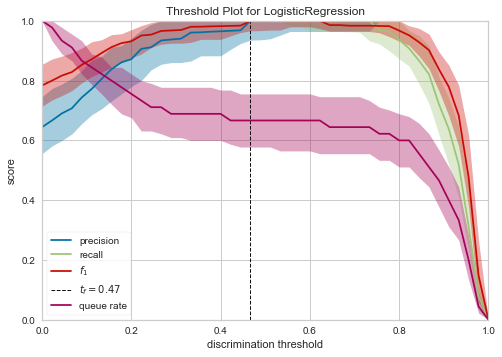

<AxesSubplot:title={'center':'Threshold Plot for LogisticRegression'}, xlabel='discrimination threshold', ylabel='score'>

In [67]:
visualizer = DiscriminationThreshold(clf_pipe, is_fitted=True)

visualizer.fit(X_test, y_test)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

#### Hyperparamètres

In [34]:
param_grid = {
    "classifier__fit_intercept": [True, False],
    # 'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear'],
    "classifier__penalty": ["none", "l1", "l2", "elasticnet"],
    "classifier__C": np.logspace(1e-2, 3, 7)
}

grid_search = GridSearchCV(clf_pipe, param_grid, cv=5, scoring="f1_macro", return_train_score=True)
grid_search

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler', MinMaxScaler()),
                                       ('classifier',
                                        LogisticRegression(solver='saga'))]),
             param_grid={'classifier__C': array([   1.02329299,    3.223542  ,   10.15468992,   31.9889511 ,
        100.77048141,  317.44366652, 1000.        ]),
                         'classifier__fit_intercept': [True, False],
                         'classifier__penalty': ['none', 'l1', 'l2',
                                                 'elasticnet']},
             return_train_score=True, scoring='f1_macro')

In [35]:
grid_search.fit(X_train, y_train)


/Users/mouslydiaw/opt/anaconda3/envs/python39/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/mouslydiaw/opt/anaconda3/envs/python39/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mouslydiaw/opt/anaconda3/envs/python39/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/mouslydiaw/opt/anaconda3/envs/python39/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mouslydiaw/opt/anaconda3/envs/python39/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore th

Best params: {'classifier__C': 1.023292992280754, 'classifier__fit_intercept': False, 'classifier__penalty': 'none'}


/Users/mouslydiaw/opt/anaconda3/envs/python39/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mouslydiaw/opt/anaconda3/envs/python39/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mouslydiaw/opt/anaconda3/envs/python39/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
70 fits failed out of a total of 280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/mouslydiaw/opt/

In [36]:

best_params = grid_search.best_params_
print(f"Best params: {best_params}")

Best params: {'classifier__C': 1.023292992280754, 'classifier__fit_intercept': False, 'classifier__penalty': 'none'}


In [37]:
print(f"Internal CV score: {grid_search.best_score_: .3f}")

Internal CV score:  0.989


In [38]:
grid_cv_results = grid_search.cv_results_

In [39]:
pd.DataFrame(grid_cv_results)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.040071      0.015602         0.010298        0.010747   
1        0.034872      0.013444         0.003411        0.000264   
2        0.010222      0.002406         0.003074        0.000272   
3        0.004832      0.001013         0.000000        0.000000   
4        0.046851      0.017163         0.004798        0.001425   
5        0.015664      0.003563         0.007490        0.003754   
6        0.008811      0.001856         0.003536        0.000736   
7        0.012732      0.003508         0.000000        0.000000   
8        0.135402      0.068725         0.011333        0.005916   
9        0.130145      0.070366         0.006825        0.003491   
10       0.065714      0.029836         0.026713        0.024087   
11       0.018379      0.006104         0.000000        0.000000   
12       0.138866      0.070775         0.018225        0.014953   
13       0.065312      0.009606         0.011204        0.006396   
14       0.017789      0.008131         0.003853        0.000691   
15       0.007668      0.002775         0.000000        0.000000   
16       0.025628      0.004624         0.005100        0.001097   
17       0.062988      0.052993         0.010669        0.006743   
18       0.021253      0.013542         0.004457        0.002898   
19       0.007978      0.003338         0.000000        0.000000   
20       0.050347      0.034570         0.005505        0.000697   
21       0.037492      0.019593         0.007600        0.005614   
22       0.018005      0.007310         0.010946        0.014158   
23       0.005824      0.001317         0.000000        0.000000   
24       0.021107      0.001083         0.003489        0.000543   
25       0.025505      0.003076         0.005004        0.001188   
26       0.026784      0.010911         0.005671        0.003136   
27       0.007779      0.002052         0.000000        0.000000   
28       0.023025      0.003975         0.004456        0.001296   
29       0.023161      0.004097         0.003971        0.000838   
30       0.014208      0.001037         0.005077        0.002617   
31       0.004742      0.000469         0.000000        0.000000   
32       0.022454      0.006254         0.004042        0.000710   
33       0.032834      0.011210         0.004413        0.000507   
34       0.034549      0.024339         0.005181        0.002004   
35       0.005085      0.000632         0.000000        0.000000   
36       0.025747      0.012248         0.004802        0.002196   
37       0.101450      0.034514         0.008968        0.001621   
38       0.036073      0.007752         0.007255        0.004031   
39       0.016930      0.012678         0.000000        0.000000   
40       0.051615      0.020403         0.011959        0.005069   
41       0.046161      0.006612         0.005465        0.001750   
42       0.044799      0.014688         0.014288        0.010760   
43       0.014539      0.010614         0.000000        0.000000   
44       0.040845      0.008831         0.008148        0.003753   
45       0.047114      0.014151         0.004147        0.001207   
46       0.043541      0.016405         0.007016        0.002176   
47       0.008369      0.002151         0.000000        0.000000   
48       0.031675      0.004815         0.005801        0.002847   
49       0.042300      0.011917         0.008289        0.002797   
50       0.035024      0.008246         0.005838        0.003629   
51       0.011901      0.007927         0.000000        0.000000   
52       0.033870      0.009426         0.005392        0.002506   
53       0.073437      0.023270         0.006859        0.001775   
54       0.058532      0.023637         0.005704        0.001988   
55       0.010424      0.006839         0.000000        0.000000   

   param_classifier__C param_classifier__fit_intercept  \
0             1.023293                            True   
1          

In [40]:
best_clf = grid_search.best_estimator_
best_clf

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('classifier',
                 LogisticRegression(C=1.023292992280754, fit_intercept=False,
                                    penalty='none', solver='saga'))])

In [41]:
print(classification_report(y_test, best_clf.predict(X_test)))

              precision    recall  f1-score   support

       False       0.99      0.98      0.98       161
        True       0.99      0.99      0.99       289

    accuracy                           0.99       450
   macro avg       0.99      0.98      0.99       450
weighted avg       0.99      0.99      0.99       450



### Features importances

In [42]:
df_feature_importance = pd.DataFrame(best_clf[-1].coef_[0],  # coefficients du modèle logistique
                                     columns=["coef"],
                                     index=grid_search.feature_names_in_,
                                    )
print(f"Shape: {df_feature_importance.shape}")
df_feature_importance.head()

Shape: (6, 1)


coef
diagonal       0.078559
height_left   -3.451787
height_right  -4.492399
margin_low   -18.669721
margin_up    -10.776802

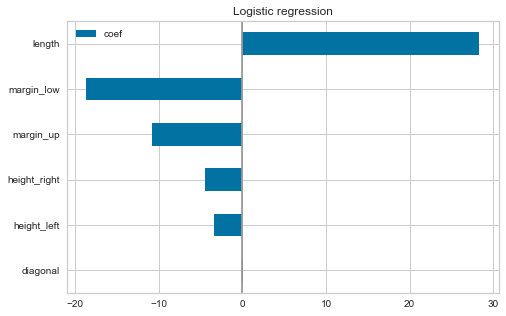

In [43]:
# top30 most important features
(df_feature_importance
 .sort_values("coef", key=lambda v: abs(v), ascending=True)
 .plot(kind="barh", figsize=(10, 5))
)
plt.title("Logistic regression")
plt.axvline(x=0, color='.6')
plt.subplots_adjust(left=.3);


In [ ]:
# Naive Bayes
# 